In [1]:
import numpy as np
np.set_printoptions(threshold=10000, suppress=True)
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# PARTIE 1

## Chargement et visualisation des données

In [ ]:
mickey = np.loadtxt('mouse.txt')
x1 = mickey[:,0]
x2 = mickey[:,1]

plt.scatter(x1, x2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Mouse data')
plt.show()

## Isolation Forest

In [ ]:

iforest = IsolationForest(n_estimators=100, max_samples='auto')
iforest.fit(mickey)

df = pd.DataFrame(mickey)
df['scores'] = iforest.decision_function(mickey)
# -1 for outliers, 1 for inliers
df['anomaly'] = iforest.predict(mickey)
df.head(20)

In [ ]:
anomaly = df.loc[df['anomaly'] == -1]
anomaly_index = list(anomaly.index)
print(len(anomaly))

## Local Outlier Factor

In [ ]:

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
pred = lof.fit_predict(mickey)

# -1 for outliers, 1 for inliers
print(pred)


## Mieux choisir le seuil de contamination

### Méthode 1 : Visualisation des anomalies - Isolation Forest

Pour cette méthode, nous allons visualiser l'histogramme des scores de l'Isolation Forest. Nous allons ensuite calculer le seuil de contamination optimal.

In [ ]:
scrores = df['scores']

# récupérer les informations de l'histogramme
frequencies, bins = np.histogram(scrores, bins=100)

# calculer la pente de chaque barre
bin_diff = np.diff(bins)
slope = np.diff(frequencies) / bin_diff[:-1]

# trouver le seuil
threshold_index = np.where(slope < -np.abs(slope).max()*0.09)[0][0]
threshold = bins[threshold_index +1]

plt.hist(scrores, bins=100)
plt.axvline(threshold, color='red', linestyle='--')


In [ ]:
nombre_sous_seuil = (df['scores'] < threshold).sum()
print("Pourcentage d'erreur : ",nombre_sous_seuil*100/len(df), '%')

### Méthode 2 : Calculer le seuil avec un Z-score - Local Outlier Factor

Pour cette méthode, nous allons calculer le seuil de contamination optimal en utilisant un Z-score.

In [ ]:
lof_scores = lof.negative_outlier_factor_
# Calcul du seuil avec Z-score
threshold = np.mean(lof_scores) - 3 * np.std(lof_scores)

print("Seuil LOF : ", threshold)
nombre_sous_seuil = (lof_scores < threshold).sum()
print("Pourcentage d'erreur LOF : ",nombre_sous_seuil*100/len(df), '%')

## Visualisation des données aberrantes

In [ ]:
iforest = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.036)
iforest.fit(mickey)
df['scores'] = iforest.decision_function(mickey)
df['anomaly'] = iforest.predict(mickey)
plt.scatter(x1, x2, c=df['anomaly'], cmap='coolwarm', s=20, edgecolors='k')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Anomalies detected by Isolation Forest')
plt.show()

In [ ]:
# print les index des anomalies
anomaly = df.loc[df['anomaly'] == -1]
anomaly_index = list(anomaly.index)
print(anomaly_index)

In [ ]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.016)
pred = lof.fit_predict(mickey)
plt.scatter(x1, x2, c=pred, cmap='coolwarm', s=20, edgecolors='k')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Anomalies detected by Local Outlier Factor')
plt.show()

In [ ]:
# print les index des anomalies
anomaly = df.loc[pred == -1]
anomaly_index = list(anomaly.index)
print(anomaly_index)

## Comparaison des méthodes

La méthode Isolation Forest avec un seuil de contamination calculé grâce à l'histogramme, permet de détecter toutes les anomalies. Cepedant, elle détecter aussi des points comme étant anormal alors qu'il ne le sont pas. D'un autre côté, la méthode Local Outlier Factor avec Z-scores permet de détecter les anomalies mais ne les trouve pas toutes. Aucune méthode n'est meilleur que l'autre, cela dépend si l'on veut détecter toutes les anomalies ou si l'on veut éviter de faux positifs.

# PARTIE 2

## Préparation des données

In [2]:
from utilsfunction import preprocess_data
from sklearn.model_selection import train_test_split

credit_card = pd.read_csv('creditcard.csv')
credit_card_features, credit_card_labels = preprocess_data(credit_card)

credit_card_features = pd.DataFrame(credit_card_features)

X_train, X_test, y_train, y_test = train_test_split(credit_card_features, credit_card_labels, test_size=0.2, random_state=42, stratify=credit_card_labels)

## Approche supervisée classique : Régression logistique

In [3]:
from utilsfunction import train__supervised_classic, print_metrics, plot_roc_pr_curves


ROC AUC score :  0.8213142636063991
Average precision score :  0.5335091815596363
Classifier report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.64      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC (Logistic Regression): 0.9589
PR AUC (Logistic Regression): 0.7416


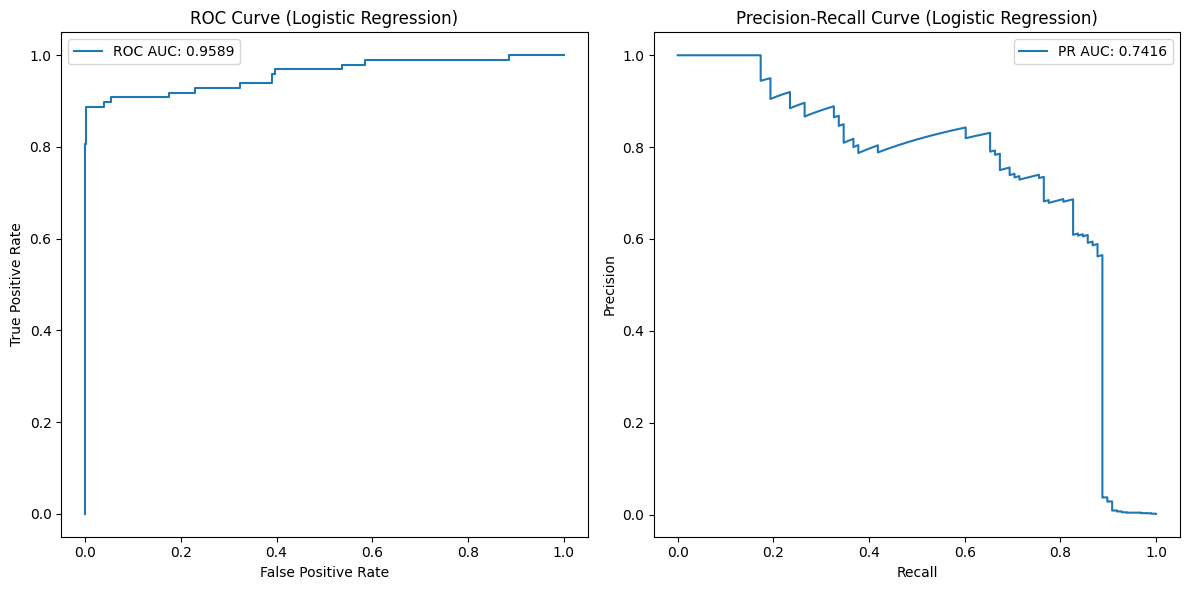

In [6]:
from sklearn.linear_model import LogisticRegression
from utilsfunction import train__supervised_classic, print_metrics, plot_roc_pr_curves
model = LogisticRegression(random_state=42)

y_pred, y_scores = train__supervised_classic(model, X_train, X_test, y_train, y_test)

print_metrics(y_test, y_pred)

plot_roc_pr_curves((y_test, y_scores), "Logistic Regression")


## Approche supervisée classique : Support Vector Machine

ROC AUC score :  0.8365130239566021
Average precision score :  0.20782425522858441
Classifier report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.31      0.68      0.42       148

    accuracy                           1.00     85443
   macro avg       0.65      0.84      0.71     85443
weighted avg       1.00      1.00      1.00     85443

ROC AUC (SVC): 0.9628
PR AUC (SVC): 0.4282


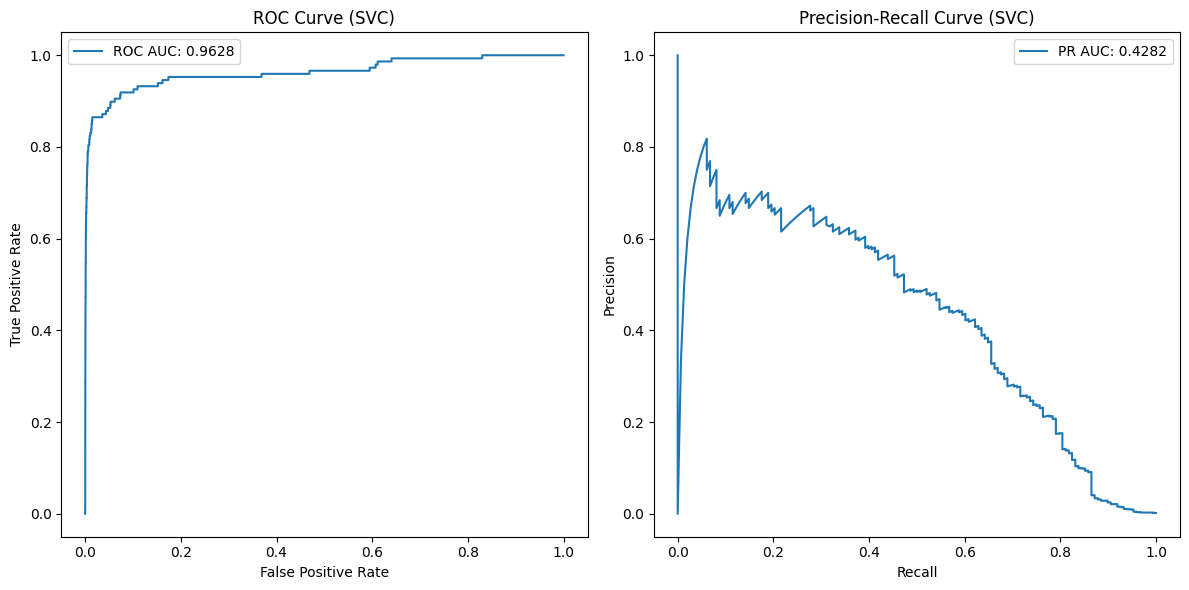

In [7]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(credit_card_features, credit_card_labels, test_size=0.3, stratify=credit_card_labels)

model = SVC(probability=True, class_weight='balanced', random_state=42)
y_pred, y_scores = train__supervised_classic(model, X_train, X_test, y_train, y_test)

print_metrics(y_test, y_pred)

plot_roc_pr_curves((y_test, y_scores), "SVC")


## UnderSampling - Tomek Links

In [4]:
from imblearn.under_sampling import TomekLinks
from sklearn.ensemble import RandomForestClassifier
from utilsfunction import train_supervised_imbalanced

tl = TomekLinks()
model = RandomForestClassifier(random_state=42)

y_pred, y_scores = train_supervised_imbalanced(tl, model, X_train, X_test, y_train, y_test)

print_metrics(y_test, y_pred)

plot_roc_pr_curves((y_test, y_scores), "Tomek Links + Random Forest")


c:\Users\runhi\miniconda3\envs\TAA\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\runhi\miniconda3\envs\TAA\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The TomekLinks or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


ValueError: too many values to unpack (expected 2)

## OverSampling

In [19]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(credit_card_features, credit_card_labels, test_size=0.3, stratify=credit_card_labels)
smote = SMOTE()
model = RandomForestClassifier(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

print("ROC AUC score : ", roc_auc_score(y_test, y_pred))
print("Average precision score : ", average_precision_score(y_test, y_pred))
print('Classifier report : \n', classification_report(y_test, y_pred))


c:\Users\runhi\miniconda3\envs\TAA\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\runhi\miniconda3\envs\TAA\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


ROC AUC score :  0.9120273359707088
Average precision score :  0.6938737279320052
Classifier report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.84      0.82      0.83       148

    accuracy                           1.00     85443
   macro avg       0.92      0.91      0.92     85443
weighted avg       1.00      1.00      1.00     85443



## Balancing

In [13]:
from imblearn.ensemble import BalancedRandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(credit_card_features, credit_card_labels, test_size=0.3, stratify=credit_card_labels)
model = BalancedRandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("ROC AUC score : ", roc_auc_score(y_test, y_pred))
print("Average precision score : ", average_precision_score(y_test, y_pred))
print('Classifier report : \n', classification_report(y_test, y_pred))

c:\Users\runhi\miniconda3\envs\TAA\lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\runhi\miniconda3\envs\TAA\lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\runhi\miniconda3\envs\TAA\lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future beh

ROC AUC score :  0.9226194304979697
Average precision score :  0.06166731652144928
Classifier report : 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.07      0.86      0.13       148

    accuracy                           0.98     85443
   macro avg       0.54      0.92      0.56     85443
weighted avg       1.00      0.98      0.99     85443



## Isolation Forest

ROC AUC (Isolation Forest): 0.9585
PR AUC (Isolation Forest): 0.1760


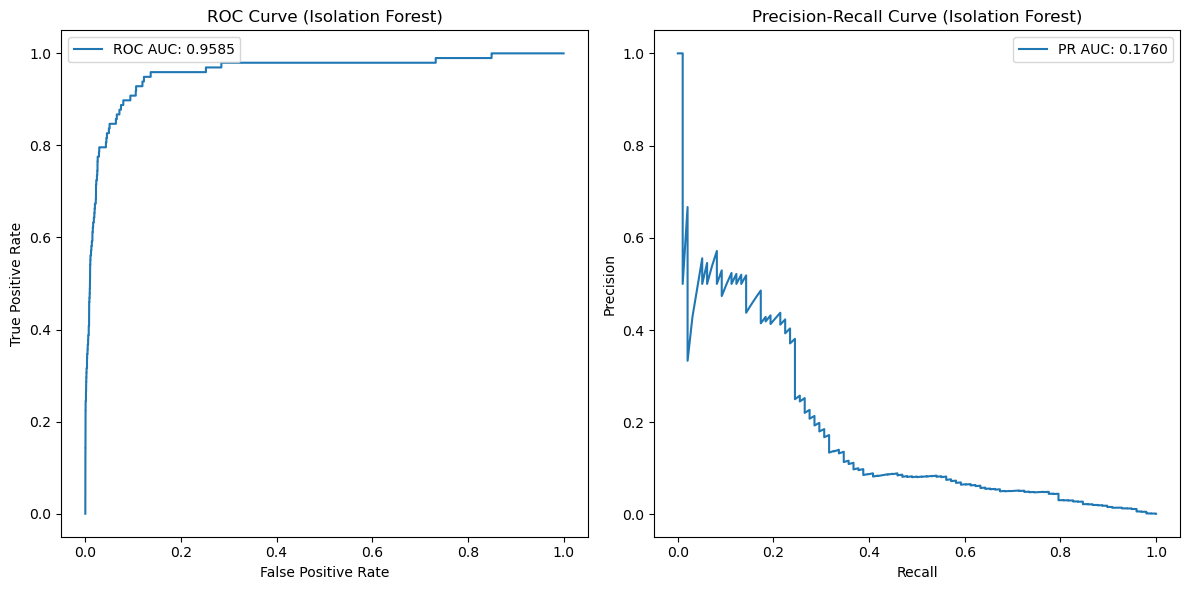

In [4]:
from utilsfunction import train_and_evaluate_isforest, plot_roc_pr_curves

iso_forest_results = train_and_evaluate_isforest(X_train, X_test, y_train, y_test)
plot_roc_pr_curves(iso_forest_results, 'Isolation Forest')

## Local Outlier Factor

In [ ]:
from utilsfunction import train_and_evaluate_lof
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler

n_neighbors_list = [5, 10, 20, 30, 50]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

result=[]
for n_neighbors in n_neighbors_list:
    x, y = train_and_evaluate_lof(X_train, X_test, y_train, y_test, n_neighbors)
    roc_auc = roc_auc_score(x, y)
    
    precision, recall, _ = precision_recall_curve(x, y)
    pr_auc = auc(recall, precision)
    result.append((n_neighbors, roc_auc, pr_auc))
    print(f'LOF with {n_neighbors} neighbors: ROC AUC = {roc_auc:.2f}, PR AUC = {pr_auc:.4f}')
    
best = max(result, key=lambda x: x[1])[0]
print(f'The best number of neighbors is {best}')


LOF with 5 neighbors: ROC AUC = 0.47, PR AUC = 0.0016


Le meilleur hyperparamètre pour l'Isolation Forest est nombre de voisin de 5.

In [ ]:

lof_results = train_and_evaluate_lof(X_train, X_test, y_train, y_test, 5)
plot_roc_pr_curves(lof_results, 'Local Outlier Factor')